### Import Libraries and load the dataset

In [25]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
print(gpus)
print("GPU device name:", tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU device name: /device:GPU:0


In [26]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
dataset = tfds.load('fashion_mnist',split='train')


### Visualize the dataset

In [27]:
import numpy as np

In [28]:
data_iterartor = dataset.as_numpy_iterator()
# Getting data out of the pipeline
print(data_iterartor.next()['image'].shape)
data_iterartor.next()['image']

(28, 28, 1)


array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 59],
        [ 77],
        [ 58],
        [ 56],
        [ 58],
        [ 57],
        [ 65],
        [ 89],
        [  2],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [245],
        [213],
        [199],
        [192],
        [188],
        [189],
        [184],
        [226],
        [ 90],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [101],
      

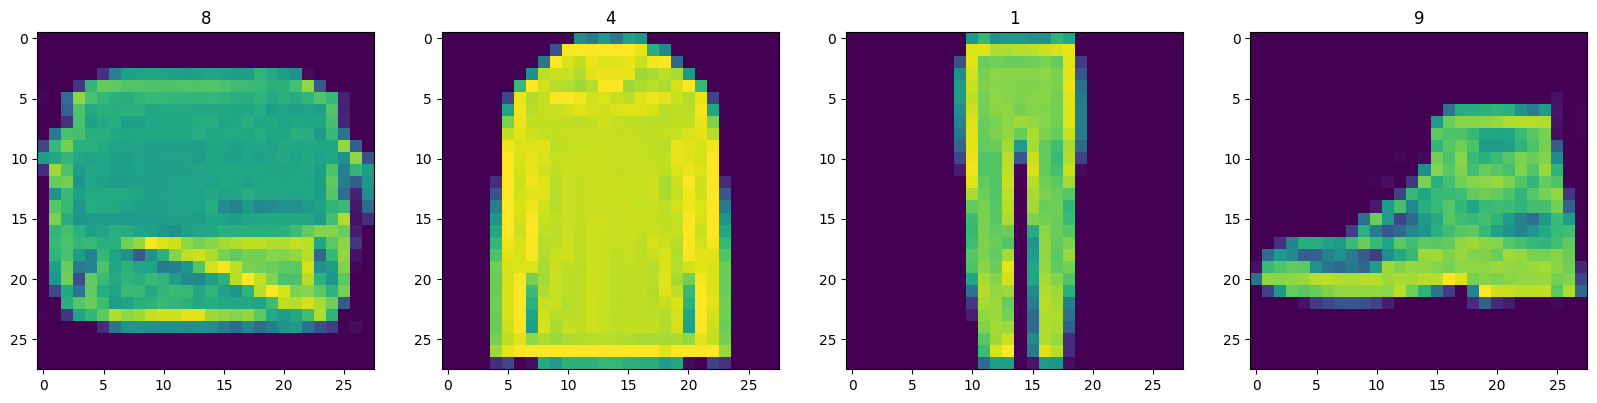

In [29]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
# loop 4 times and get images
for idx in range(4):
    # Grab an image and label
    sample = data_iterartor.next()
    # plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as plot title
    ax[idx].title.set_text(sample['label'])

In [30]:
# Scale and return images
def scale_images(data):
    image = data['image']
    return image / 255

In [31]:
dataset = dataset.map(scale_images)
# Cache the dataset for the batch
dataset = dataset.cache()
dataset = dataset.shuffle(60000)
# Batch into 128 images per sample
dataset = dataset.batch(128)
# Reduces the likelihood of bottlenecking
dataset = dataset.prefetch(64)

In [32]:
dataset.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Building Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

#### Generator

In [34]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7*7*128
    # Begginings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D()) # double the spatial quality (7,7,128) -> (14,14,128)
    model.add(Conv2D(128,5,padding='same')) 
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D()) 
    model.add(Conv2D(128,5,padding='same')) 
    model.add(LeakyReLU(0.2))

    # Convolution block 1
    model.add(Conv2D(128,4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128,4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv Layer to get to one channel
    model.add(Conv2D(1,4,padding='same', activation='sigmoid'))


    return model

In [35]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 120ms/step
(4, 28, 28, 1)


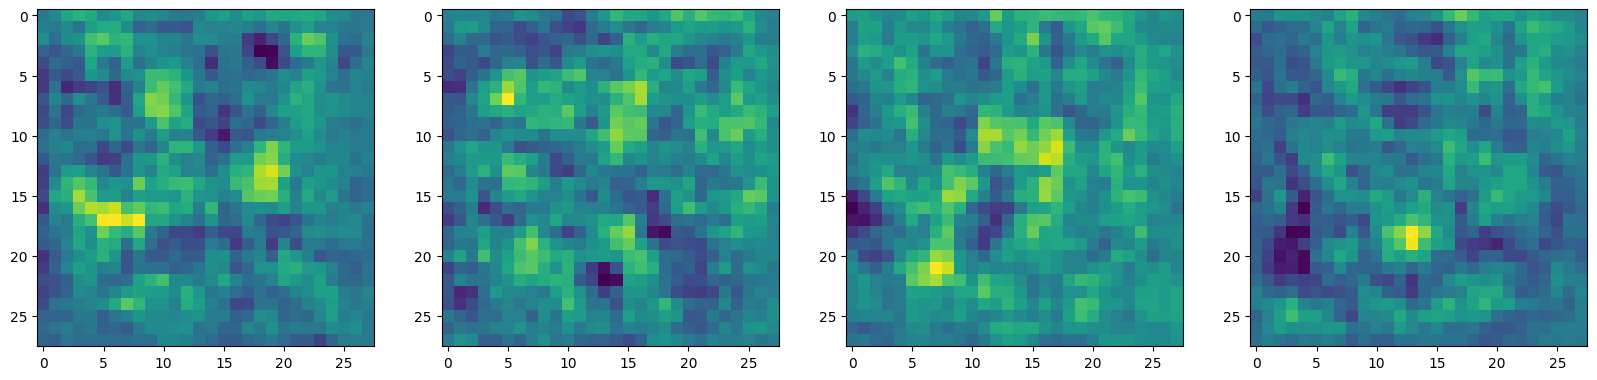

In [36]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1)) # generating 4 images by passing 128 random numbers to the model
print(img.shape)
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,image in enumerate(img):
    ax[idx].imshow(np.squeeze(img[idx]))    

#### Discriminator

In [37]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32,5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1 , activation='sigmoid')) 

    return model

In [38]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [39]:
img.shape

(4, 28, 28, 1)

In [40]:
print(discriminator.predict(np.expand_dims(img[0],0)))   # expand_dims is used because here we are predicting for a single image but are discriminator takes input in batch
print(discriminator.predict(img)) # If you have a batch of images no need to do expand_dims

1/1 [==============================] - 0s 65ms/step
[[0.5059337]]
1/1 [==============================] - 0s 23ms/step
[[0.5059347]
 [0.5060255]
 [0.5060806]
 [0.5059176]]


## Construct Training Loop

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [42]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [43]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [44]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args,**kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self , g_opt , d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args,**kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False) # Generating 128 fake images by passing 128 random numbers for each image

        # Train the discriminator
        with tf.GradientTape() as d_tape: # d_tape will be used to calculate the gradients for all the variables in the model
            # Pass the real and fake images to the dicriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real,yhat_fake],axis=0)  # (Predicted values)

            # Create labels for real and fake images (True values)
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0) # Discriminator should output 0 for real images and 1 for fake images

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real,noise_fake], axis=0)

            # Calculate Loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropogation - nn Learn
        dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)),training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images,training=False)

            # Calculate loss 
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)     # The true labels should be 0 as the generated wants the discriminator to think that these are REAL images
            ''' We are implying that our generated images are actually REAL images.
            So we reward our generator for faking out the discriminator i.e. if the
            discriminator predicts that the generated image is real'''
        
        # Back propogation 
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss , "g_loss":total_g_loss}

In [45]:
# Create instance of subclass model
fashion = FashionGAN(generator,discriminator)
fashion.compile(g_opt,d_opt,g_loss,d_loss)

In [46]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [47]:
class ModelMonitor(Callback):
    def __init__(self,num_img=3,latent_dim=128): # latent_dim is the number of random numbers you pass to the generator to generate an image in our case 128
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self,epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('GAN_images',f'generated_img_{epoch}_{i}.png'))

In [ ]:
hist = fashion.fit(dataset,epochs=300, callbacks=[ModelMonitor()]) ### WILL TAKE A LOT OF TIME